## データセットの準備

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
def space_clean(row):
    row = row.replace(". ", "").replace(" .", "").replace("  ", " ")
    return row


def canonicalize(smiles):
    try:
        new_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True)
    except:
        new_smiles = None
    return new_smiles

In [3]:
df = pd.read_csv("./data/inchi_23l_reaction_t5_ready.csv")

In [4]:
# 必須カラムの存在チェックと補完
required_cols = ["REACTANT", "CATALYST", "REAGENT", "SOLVENT", "PRODUCT"]
for col in required_cols:
    if col not in df.columns:
        df[col] = ""

# 必要に応じてYIELDを標準化（0-1に正規化）
if "YIELD" in df.columns and df["YIELD"].max() >= 100:
    df["YIELD"] = df["YIELD"].clip(0, 100) / 100
else:
    df["YIELD"] = None

In [5]:
for col in ["REAGENT", "REACTANT", "PRODUCT"]:
    df[col] = df[col].apply(space_clean)
    df[col] = df[col].apply(lambda x: canonicalize(x) if x != " " else " ")
    df = df[~df[col].isna()].reset_index(drop=True)
    df[col] = df[col].apply(lambda x: ".".join(sorted(x.split("."))))

In [6]:
df["REAGENT"] = df["CATALYST"].fillna(" ") + "." + df["REAGENT"].fillna(" ")

In [7]:
df = df.loc[df[["YIELD"]].drop_duplicates().index].reset_index(drop=True)

## モデルの読み込み

In [8]:
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration, AutoConfig, PreTrainedModel

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

/root/ReactionT5-bo-yield/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class ReactionT5Yield(PreTrainedModel):
    config_class  = AutoConfig
    def __init__(self, config):
        super().__init__(config)
        self.config = config
        self.model = T5ForConditionalGeneration.from_pretrained(self.config._name_or_path)
        self.model.resize_token_embeddings(self.config.vocab_size)
        self.fc1 = nn.Linear(self.config.hidden_size, self.config.hidden_size//2)
        self.fc2 = nn.Linear(self.config.hidden_size, self.config.hidden_size//2)
        self.fc3 = nn.Linear(self.config.hidden_size//2*2, self.config.hidden_size)
        self.fc4 = nn.Linear(self.config.hidden_size, self.config.hidden_size)
        self.fc5 = nn.Linear(self.config.hidden_size, 1)

        self._init_weights(self.fc1)
        self._init_weights(self.fc2)
        self._init_weights(self.fc3)
        self._init_weights(self.fc4)
        self._init_weights(self.fc5)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, inputs):
        device = inputs['input_ids'].device

        with torch.no_grad():
            encoder_outputs = self.model.encoder(
                input_ids=inputs['input_ids'],
                attention_mask=inputs.get('attention_mask', None),
            )
            encoder_hidden_states = encoder_outputs[0]  # (B, L, H)

            dec_input_ids = torch.full(
                (inputs['input_ids'].size(0), 1),
                self.config.decoder_start_token_id,
                dtype=torch.long,
                device=device,
            )

            outputs = self.model.decoder(
                input_ids=dec_input_ids,
                encoder_hidden_states=encoder_hidden_states,
            )
            last_hidden_states = outputs[0]  # (B, 1, H)

        output1 = self.fc1(last_hidden_states.view(-1, self.config.hidden_size))
        output2 = self.fc2(encoder_hidden_states[:, 0, :].view(-1, self.config.hidden_size))
        output = self.fc3(torch.hstack((output1, output2)))
        output = self.fc4(output)
        output = self.fc5(output)
        return output * 100



In [10]:
# 収率予測（スカラー出力）
yield_tokenizer = AutoTokenizer.from_pretrained("sagawa/ReactionT5v2-yield")
yield_model = ReactionT5Yield.from_pretrained("sagawa/ReactionT5v2-yield")

In [11]:
def predict_yield(input_str: str) -> float:
    inputs = yield_tokenizer([input_str], return_tensors="pt", truncation=True)
    with torch.no_grad():
        output = yield_model(inputs)
    return output.item()

## Optunaによる探索

In [12]:
import optuna

In [13]:
reactant_list = sorted(df["REACTANT"].unique())
reagent_list = sorted(df["REAGENT"].unique())
product_list = sorted(df["PRODUCT"].unique())

In [14]:
len(reactant_list), len(reagent_list), len(product_list)

(33, 23, 24)

In [15]:
product_dict = {
    (row["REACTANT"], row["REAGENT"]): row["PRODUCT"]
    for _, row in df.iterrows()
}

In [16]:
true_yield_dict = {
    (row["REACTANT"], row["REAGENT"], row["PRODUCT"]): row["YIELD"]
    for _, row in df.iterrows()
}

In [17]:
def objective(trial):

    yield_model.to("cpu")
    try:
        torch.cuda.empty_cache()
    except Exception:
        pass
    
    reactant = trial.suggest_categorical("reactant", reactant_list)
    reagent = trial.suggest_categorical("reagent", reagent_list)
    product = product_dict.get((reactant, reagent))

    input_str = f"REACTANT:{reactant}REAGENT:{reagent}PRODUCT:{product}"

    try:
        pred_yield = predict_yield(input_str)

        # ground truth を取得
        key = (reactant, reagent, product)
        if key not in true_yield_dict:
            print(f"❗ No ground truth for: {reactant} + {reagent} → {product}")
            true_yield = 0.0
        else:
            true_yield = true_yield_dict.get(key)

        # 誤差の計算
        if true_yield is not None:
            true_yield_pct = true_yield * 100
            error = pred_yield - true_yield_pct 
            print(f"🔎 {reactant} + {reagent} → {product}")
            print(f"   📈 Predicted: {pred_yield:.2f}%")
            print(f"   🧪 Ground truth: {true_yield_pct:.2f}%" if true_yield is not None else "   🧪 Ground truth: None")
            print(f"   ❗ Error: {error:+.2f}%")
        else:
            print(f"❔ No ground truth for: {reactant} + {reagent}")
            error = None

        if pred_yield < 0 or pred_yield > 100:
            return 0.0

        return pred_yield  # 目的関数は「予測収率の最大化」
    except Exception as e:
        print(f"❌ Error during trial: {e}")
        return 0.0

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-09-11 14:48:10,338] A new study created in memory with name: no-name-be6194c4-2bc3-4923-8f4c-b70a526bb252
[I 2025-09-11 14:48:10,512] Trial 0 finished with value: 66.0856704711914 and parameters: {'reactant': 'COc1cc(Cl)ccc1F', 'reagent': 'C1CCC([PH+](C2CCCCC2)C2CCCCC2)CC1.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 0 with value: 66.0856704711914.
[I 2025-09-11 14:48:10,631] Trial 1 finished with value: 72.73208618164062 and parameters: {'reactant': 'CCOC(=O)c1ccc(Cl)c(F)c1', 'reagent': 'COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.


🔎 COc1cc(Cl)ccc1F + C1CCC([PH+](C2CCCCC2)C2CCCCC2)CC1.F[B-](F)(F)F.OB(O)B(O)O → COc1cc(B(O)O)ccc1F
   📈 Predicted: 66.09%
   🧪 Ground truth: 6.55%
   ❗ Error: +59.54%
🔎 CCOC(=O)c1ccc(Cl)c(F)c1 + COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O → CCOC(=O)c1ccc(B(O)O)c(F)c1
   📈 Predicted: 72.73%
   🧪 Ground truth: 43.93%
   ❗ Error: +28.80%


[I 2025-09-11 14:48:10,761] Trial 2 finished with value: 58.120548248291016 and parameters: {'reactant': 'Brc1ccccc1-c1ccccc1', 'reagent': 'CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:10,865] Trial 3 finished with value: 69.51631927490234 and parameters: {'reactant': 'Cc1cc(F)ccc1Cl', 'reagent': 'c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.


🔎 Brc1ccccc1-c1ccccc1 + CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O → OB(O)c1ccccc1-c1ccccc1
   📈 Predicted: 58.12%
   🧪 Ground truth: 22.93%
   ❗ Error: +35.20%
🔎 Cc1cc(F)ccc1Cl + c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → Cc1cc(F)ccc1B(O)O
   📈 Predicted: 69.52%
   🧪 Ground truth: 36.20%
   ❗ Error: +33.32%


[I 2025-09-11 14:48:10,979] Trial 4 finished with value: 68.24549865722656 and parameters: {'reactant': 'COc1ncc(Br)c(OC)n1', 'reagent': 'CN(C)c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:11,088] Trial 5 finished with value: 61.39530563354492 and parameters: {'reactant': 'Brc1ccccc1-c1ccccc1', 'reagent': 'Cc1cc(C)cc(P(c2cc(C)cc(C)c2)c2cc(C)cc(C)c2)c1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.


🔎 COc1ncc(Br)c(OC)n1 + CN(C)c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ncc(B(O)O)c(OC)n1
   📈 Predicted: 68.25%
   🧪 Ground truth: 3.52%
   ❗ Error: +64.73%
🔎 Brc1ccccc1-c1ccccc1 + Cc1cc(C)cc(P(c2cc(C)cc(C)c2)c2cc(C)cc(C)c2)c1.OB(O)B(O)O → OB(O)c1ccccc1-c1ccccc1
   📈 Predicted: 61.40%
   🧪 Ground truth: 59.51%
   ❗ Error: +1.88%


[I 2025-09-11 14:48:11,248] Trial 6 finished with value: 63.05832290649414 and parameters: {'reactant': 'Clc1ccc(-c2ccccc2)cc1', 'reagent': 'c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:11,364] Trial 7 finished with value: 42.91735076904297 and parameters: {'reactant': 'Cc1c(N)cccc1Cl', 'reagent': 'c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.


🔎 Clc1ccc(-c2ccccc2)cc1 + c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O → OB(O)c1ccc(-c2ccccc2)cc1
   📈 Predicted: 63.06%
   🧪 Ground truth: 91.08%
   ❗ Error: -28.02%
🔎 Cc1c(N)cccc1Cl + c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O → Cc1c(N)cccc1B(O)O
   📈 Predicted: 42.92%
   🧪 Ground truth: 71.32%
   ❗ Error: -28.40%


[I 2025-09-11 14:48:11,473] Trial 8 finished with value: 56.47077560424805 and parameters: {'reactant': 'COC(=O)c1ccc(Cl)cc1', 'reagent': 'CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:11,571] Trial 9 finished with value: 63.97572326660156 and parameters: {'reactant': 'Brc1ccc2c(c1)OCO2', 'reagent': 'C[PH+](C)C.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:11,673] Trial 10 finished with value: 72.73208618164062 and parameters: {'reactant': 'CCOC(=O)c1ccc(Cl)c(F)c1', 'reagent': 'COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.


🔎 COC(=O)c1ccc(Cl)cc1 + CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → COC(=O)c1ccc(B(O)O)cc1
   📈 Predicted: 56.47%
   🧪 Ground truth: 28.24%
   ❗ Error: +28.23%
🔎 Brc1ccc2c(c1)OCO2 + C[PH+](C)C.F[B-](F)(F)F.OB(O)B(O)O → OB(O)c1ccc2c(c1)OCO2
   📈 Predicted: 63.98%
   🧪 Ground truth: 50.63%
   ❗ Error: +13.35%
🔎 CCOC(=O)c1ccc(Cl)c(F)c1 + COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O → CCOC(=O)c1ccc(B(O)O)c(F)c1
   📈 Predicted: 72.73%
   🧪 Ground truth: 43.93%
   ❗ Error: +28.80%


[I 2025-09-11 14:48:11,772] Trial 11 finished with value: 72.73208618164062 and parameters: {'reactant': 'CCOC(=O)c1ccc(Cl)c(F)c1', 'reagent': 'COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:11,885] Trial 12 finished with value: 72.73208618164062 and parameters: {'reactant': 'CCOC(=O)c1ccc(Cl)c(F)c1', 'reagent': 'COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.


🔎 CCOC(=O)c1ccc(Cl)c(F)c1 + COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O → CCOC(=O)c1ccc(B(O)O)c(F)c1
   📈 Predicted: 72.73%
   🧪 Ground truth: 43.93%
   ❗ Error: +28.80%
🔎 CCOC(=O)c1ccc(Cl)c(F)c1 + COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O → CCOC(=O)c1ccc(B(O)O)c(F)c1
   📈 Predicted: 72.73%
   🧪 Ground truth: 43.93%
   ❗ Error: +28.80%


[I 2025-09-11 14:48:11,989] Trial 13 finished with value: 63.076866149902344 and parameters: {'reactant': 'CCOC(=O)c1ccc(Cl)c(F)c1', 'reagent': 'CN(C)c1ccccc1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:12,082] Trial 14 finished with value: 72.07410430908203 and parameters: {'reactant': 'N#Cc1ccc(Cl)cc1F', 'reagent': 'COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:12,179] Trial 15 finished with value: 56.870574951171875 and parameters: {'reactant': 'Brc1ccc2occc2c1', 'reagent': 'Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.


🔎 CCOC(=O)c1ccc(Cl)c(F)c1 + CN(C)c1ccccc1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O → CCOC(=O)c1ccc(B(O)O)c(F)c1
   📈 Predicted: 63.08%
   🧪 Ground truth: 37.63%
   ❗ Error: +25.45%
🔎 N#Cc1ccc(Cl)cc1F + COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O → N#Cc1ccc(B(O)O)cc1F
   📈 Predicted: 72.07%
   🧪 Ground truth: 48.97%
   ❗ Error: +23.10%
🔎 Brc1ccc2occc2c1 + Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → OB(O)c1ccc2occc2c1
   📈 Predicted: 56.87%
   🧪 Ground truth: 43.90%
   ❗ Error: +12.97%


[I 2025-09-11 14:48:12,291] Trial 16 finished with value: 68.61612701416016 and parameters: {'reactant': 'FC(F)(F)c1ccc(Cl)cc1', 'reagent': 'COc1cc(C(C)(C)C)cc(C(C)(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:12,411] Trial 17 finished with value: 71.2689208984375 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc2[nH]ccc2c1', 'reagent': 'c1ccc(-c2nn(-c3ccccc3)c(-c3ccccc3)c2-n2nccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.


🔎 FC(F)(F)c1ccc(Cl)cc1 + COc1cc(C(C)(C)C)cc(C(C)(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → OB(O)c1ccc(C(F)(F)F)cc1
   📈 Predicted: 68.62%
   🧪 Ground truth: 73.09%
   ❗ Error: -4.47%
🔎 CN(C)S(=O)(=O)Oc1ccc2[nH]ccc2c1 + c1ccc(-c2nn(-c3ccccc3)c(-c3ccccc3)c2-n2nccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → OB(O)c1ccc2[nH]ccc2c1
   📈 Predicted: 71.27%
   🧪 Ground truth: 82.92%
   ❗ Error: -11.65%


[I 2025-09-11 14:48:12,501] Trial 18 finished with value: 63.66933059692383 and parameters: {'reactant': 'Brc1ccsc1', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:12,593] Trial 19 finished with value: 69.34134674072266 and parameters: {'reactant': 'Clc1cnc2ccccc2c1', 'reagent': 'Fc1ccc(P(c2ccc(F)cc2)c2ccc(F)cc2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.


🔎 Brc1ccsc1 + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → OB(O)c1ccsc1
   📈 Predicted: 63.67%
   🧪 Ground truth: 77.47%
   ❗ Error: -13.81%
🔎 Clc1cnc2ccccc2c1 + Fc1ccc(P(c2ccc(F)cc2)c2ccc(F)cc2)cc1.OB(O)B(O)O → OB(O)c1cnc2ccccc2c1
   📈 Predicted: 69.34%
   🧪 Ground truth: 20.49%
   ❗ Error: +48.85%


[I 2025-09-11 14:48:12,711] Trial 20 finished with value: 65.88607025146484 and parameters: {'reactant': 'CCOC(=O)C(C)(C)Oc1ccc(Cl)cc1', 'reagent': 'CC(C)c1cc(C(C)C)c(-c2ccccc2P(c2ccccc2)c2ccccc2)c(C(C)C)c1.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:12,814] Trial 21 finished with value: 72.73208618164062 and parameters: {'reactant': 'CCOC(=O)c1ccc(Cl)c(F)c1', 'reagent': 'COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O'}. Best is trial 1 with value: 72.73208618164062.
[I 2025-09-11 14:48:12,900] Trial 22 finished with value: 74.28561401367188 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O'}. Best is trial 22 with value: 74.28561401367188.


🔎 CCOC(=O)C(C)(C)Oc1ccc(Cl)cc1 + CC(C)c1cc(C(C)C)c(-c2ccccc2P(c2ccccc2)c2ccccc2)c(C(C)C)c1.OB(O)B(O)O → CCOC(=O)C(C)(C)Oc1ccc(B(O)O)cc1
   📈 Predicted: 65.89%
   🧪 Ground truth: 32.94%
   ❗ Error: +32.95%
🔎 CCOC(=O)c1ccc(Cl)c(F)c1 + COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O → CCOC(=O)c1ccc(B(O)O)c(F)c1
   📈 Predicted: 72.73%
   🧪 Ground truth: 43.93%
   ❗ Error: +28.80%
🔎 COc1ccc(Cl)cc1F + COc1ccccc1P(c1ccccc1OC)c1ccccc1OC.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 74.29%
   🧪 Ground truth: 15.05%
   ❗ Error: +59.24%


[I 2025-09-11 14:48:12,999] Trial 23 finished with value: 77.02468872070312 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 23 with value: 77.02468872070312.
[I 2025-09-11 14:48:13,091] Trial 24 finished with value: 77.02468872070312 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 23 with value: 77.02468872070312.
[I 2025-09-11 14:48:13,187] Trial 25 finished with value: 77.02468872070312 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 23 with value: 77.02468872070312.


🔎 COc1ccc(Cl)cc1F + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 77.02%
   🧪 Ground truth: 33.28%
   ❗ Error: +43.74%
🔎 COc1ccc(Cl)cc1F + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 77.02%
   🧪 Ground truth: 33.28%
   ❗ Error: +43.74%
🔎 COc1ccc(Cl)cc1F + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 77.02%
   🧪 Ground truth: 33.28%
   ❗ Error: +43.74%


[I 2025-09-11 14:48:13,281] Trial 26 finished with value: 77.02468872070312 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 23 with value: 77.02468872070312.
[I 2025-09-11 14:48:13,365] Trial 27 finished with value: 77.02468872070312 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 23 with value: 77.02468872070312.
[I 2025-09-11 14:48:13,475] Trial 28 finished with value: 78.22433471679688 and parameters: {'reactant': 'Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.


🔎 COc1ccc(Cl)cc1F + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 77.02%
   🧪 Ground truth: 33.28%
   ❗ Error: +43.74%
🔎 COc1ccc(Cl)cc1F + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 77.02%
   🧪 Ground truth: 33.28%
   ❗ Error: +43.74%
🔎 Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → Cc1nc2cc(B(O)O)ccc2s1
   📈 Predicted: 78.22%
   🧪 Ground truth: 52.69%
   ❗ Error: +25.53%


[I 2025-09-11 14:48:13,569] Trial 29 finished with value: 76.9076919555664 and parameters: {'reactant': 'Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'reagent': 'CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.
[I 2025-09-11 14:48:13,662] Trial 30 finished with value: 75.4543685913086 and parameters: {'reactant': 'N#Cc1ccc(Br)cc1F', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.
[I 2025-09-11 14:48:13,741] Trial 31 finished with value: 70.82689666748047 and parameters: {'reactant': 'COc1ccc(Br)cc1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.


❗ No ground truth for: Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O → None
🔎 Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O → None
   📈 Predicted: 76.91%
   🧪 Ground truth: 0.00%
   ❗ Error: +76.91%
🔎 N#Cc1ccc(Br)cc1F + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → N#Cc1ccc(B(O)O)cc1F
   📈 Predicted: 75.45%
   🧪 Ground truth: 50.09%
   ❗ Error: +25.36%
🔎 COc1ccc(Br)cc1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ccc(B(O)O)cc1
   📈 Predicted: 70.83%
   🧪 Ground truth: 79.66%
   ❗ Error: -8.84%


[I 2025-09-11 14:48:13,830] Trial 32 finished with value: 76.3082275390625 and parameters: {'reactant': 'COc1ccc(Br)cc1F', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.
[I 2025-09-11 14:48:13,921] Trial 33 finished with value: 70.44136810302734 and parameters: {'reactant': 'Cc1cccc(C)c1Cl', 'reagent': 'COc1cccc(OC)c1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.
[I 2025-09-11 14:48:14,022] Trial 34 finished with value: 74.9722671508789 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc(-c2ccccc2)cc1', 'reagent': 'c1ccc(P(c2ccccc2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.


🔎 COc1ccc(Br)cc1F + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 76.31%
   🧪 Ground truth: 55.90%
   ❗ Error: +20.41%
🔎 Cc1cccc(C)c1Cl + COc1cccc(OC)c1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O → Cc1cccc(C)c1B(O)O
   📈 Predicted: 70.44%
   🧪 Ground truth: 10.76%
   ❗ Error: +59.68%
🔎 CN(C)S(=O)(=O)Oc1ccc(-c2ccccc2)cc1 + c1ccc(P(c2ccccc2)C2CCCCC2)cc1.OB(O)B(O)O → OB(O)c1ccc(-c2ccccc2)cc1
   📈 Predicted: 74.97%
   🧪 Ground truth: 77.51%
   ❗ Error: -2.54%


[I 2025-09-11 14:48:14,112] Trial 35 finished with value: 60.12196350097656 and parameters: {'reactant': 'Cc1ncccc1Br', 'reagent': 'c1ccc(-c2cc3ccccc3n2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.
[I 2025-09-11 14:48:14,232] Trial 36 finished with value: 64.57032775878906 and parameters: {'reactant': 'COC(=O)c1ccc(Br)cc1', 'reagent': 'COc1ccccc1C1=C(P(C2CCCCC2)C2CCCCC2)C2c3ccccc3C1c1ccccc12.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.


🔎 Cc1ncccc1Br + c1ccc(-c2cc3ccccc3n2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → Cc1ncccc1B(O)O
   📈 Predicted: 60.12%
   🧪 Ground truth: 54.96%
   ❗ Error: +5.16%
🔎 COC(=O)c1ccc(Br)cc1 + COc1ccccc1C1=C(P(C2CCCCC2)C2CCCCC2)C2c3ccccc3C1c1ccccc12.OB(O)B(O)O → COC(=O)c1ccc(B(O)O)cc1
   📈 Predicted: 64.57%
   🧪 Ground truth: 69.06%
   ❗ Error: -4.49%


[I 2025-09-11 14:48:14,326] Trial 37 finished with value: 66.93592071533203 and parameters: {'reactant': 'Brc1cnc2ccccc2c1', 'reagent': 'C1CCC([PH+](C2CCCCC2)C2CCCCC2)CC1.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.
[I 2025-09-11 14:48:14,412] Trial 38 finished with value: 73.2723388671875 and parameters: {'reactant': 'Brc1ccc(-c2ccccc2)cc1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.


🔎 Brc1cnc2ccccc2c1 + C1CCC([PH+](C2CCCCC2)C2CCCCC2)CC1.F[B-](F)(F)F.OB(O)B(O)O → OB(O)c1cnc2ccccc2c1
   📈 Predicted: 66.94%
   🧪 Ground truth: 19.71%
   ❗ Error: +47.23%
🔎 Brc1ccc(-c2ccccc2)cc1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → OB(O)c1ccc(-c2ccccc2)cc1
   📈 Predicted: 73.27%
   🧪 Ground truth: 96.01%
   ❗ Error: -22.74%


[I 2025-09-11 14:48:14,539] Trial 39 finished with value: 51.38967514038086 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc2ncccc2c1', 'reagent': 'CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.
[I 2025-09-11 14:48:14,649] Trial 40 finished with value: 76.04617309570312 and parameters: {'reactant': 'Clc1ccc2c(c1)OCO2', 'reagent': 'c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.
[I 2025-09-11 14:48:14,738] Trial 41 finished with value: 77.02468872070312 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.


🔎 CN(C)S(=O)(=O)Oc1ccc2ncccc2c1 + CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O → OB(O)c1ccc2ncccc2c1
   📈 Predicted: 51.39%
   🧪 Ground truth: 41.87%
   ❗ Error: +9.52%
🔎 Clc1ccc2c(c1)OCO2 + c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → OB(O)c1ccc2c(c1)OCO2
   📈 Predicted: 76.05%
   🧪 Ground truth: 69.34%
   ❗ Error: +6.71%
🔎 COc1ccc(Cl)cc1F + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 77.02%
   🧪 Ground truth: 33.28%
   ❗ Error: +43.74%


[I 2025-09-11 14:48:14,826] Trial 42 finished with value: 77.02468872070312 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 28 with value: 78.22433471679688.
[I 2025-09-11 14:48:14,919] Trial 43 finished with value: 78.23442077636719 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:15,024] Trial 44 finished with value: 71.67645263671875 and parameters: {'reactant': 'CN(C)C(=O)c1ccc(Cl)cc1', 'reagent': 'CN(C)c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 COc1ccc(Cl)cc1F + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 77.02%
   🧪 Ground truth: 33.28%
   ❗ Error: +43.74%
🔎 CCOC(=O)c1cc(Br)cn1CC + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 78.23%
   🧪 Ground truth: 29.09%
   ❗ Error: +49.15%
🔎 CN(C)C(=O)c1ccc(Cl)cc1 + CN(C)c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → CN(C)C(=O)c1ccc(B(O)O)cc1
   📈 Predicted: 71.68%
   🧪 Ground truth: 37.70%
   ❗ Error: +33.98%


[I 2025-09-11 14:48:15,137] Trial 45 finished with value: 76.15909576416016 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'Cc1cc(C)cc(P(c2cc(C)cc(C)c2)c2cc(C)cc(C)c2)c1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:15,223] Trial 46 finished with value: 73.56736755371094 and parameters: {'reactant': 'Clc1ccc2[nH]ccc2c1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:15,316] Trial 47 finished with value: 64.46636962890625 and parameters: {'reactant': 'FC(F)(F)c1ccc(Br)cc1', 'reagent': 'CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CCOC(=O)c1cc(Br)cn1CC + Cc1cc(C)cc(P(c2cc(C)cc(C)c2)c2cc(C)cc(C)c2)c1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 76.16%
   🧪 Ground truth: 23.52%
   ❗ Error: +52.63%
🔎 Clc1ccc2[nH]ccc2c1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → OB(O)c1ccc2[nH]ccc2c1
   📈 Predicted: 73.57%
   🧪 Ground truth: 57.31%
   ❗ Error: +16.26%
🔎 FC(F)(F)c1ccc(Br)cc1 + CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → OB(O)c1ccc(C(F)(F)F)cc1
   📈 Predicted: 64.47%
   🧪 Ground truth: 56.46%
   ❗ Error: +8.00%


[I 2025-09-11 14:48:15,407] Trial 48 finished with value: 64.9549331665039 and parameters: {'reactant': 'COc1cc(Cl)ccc1F', 'reagent': 'C[PH+](C)C.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:15,507] Trial 49 finished with value: 78.22433471679688 and parameters: {'reactant': 'Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 COc1cc(Cl)ccc1F + C[PH+](C)C.F[B-](F)(F)F.OB(O)B(O)O → COc1cc(B(O)O)ccc1F
   📈 Predicted: 64.95%
   🧪 Ground truth: 15.84%
   ❗ Error: +49.11%
🔎 Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → Cc1nc2cc(B(O)O)ccc2s1
   📈 Predicted: 78.22%
   🧪 Ground truth: 52.69%
   ❗ Error: +25.53%


[I 2025-09-11 14:48:15,616] Trial 50 finished with value: 75.58328247070312 and parameters: {'reactant': 'Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'reagent': 'CN(C)c1ccccc1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:15,713] Trial 51 finished with value: 78.23442077636719 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:15,810] Trial 52 finished with value: 78.23442077636719 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + CN(C)c1ccccc1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O → Cc1nc2cc(B(O)O)ccc2s1
   📈 Predicted: 75.58%
   🧪 Ground truth: 4.83%
   ❗ Error: +70.76%
🔎 CCOC(=O)c1cc(Br)cn1CC + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 78.23%
   🧪 Ground truth: 29.09%
   ❗ Error: +49.15%
🔎 CCOC(=O)c1cc(Br)cn1CC + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 78.23%
   🧪 Ground truth: 29.09%
   ❗ Error: +49.15%


[I 2025-09-11 14:48:15,914] Trial 53 finished with value: 63.4122428894043 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:16,007] Trial 54 finished with value: 74.51725006103516 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:16,103] Trial 55 finished with value: 68.27042388916016 and parameters: {'reactant': 'Cc1cc(F)ccc1Cl', 'reagent': 'COc1cc(C(C)(C)C)cc(C(C)(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CCOC(=O)c1cc(Br)cn1CC + c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 63.41%
   🧪 Ground truth: 58.39%
   ❗ Error: +5.02%
🔎 CCOC(=O)c1cc(Br)cn1CC + Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 74.52%
   🧪 Ground truth: 43.34%
   ❗ Error: +31.18%
🔎 Cc1cc(F)ccc1Cl + COc1cc(C(C)(C)C)cc(C(C)(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → Cc1cc(F)ccc1B(O)O
   📈 Predicted: 68.27%
   🧪 Ground truth: 16.44%
   ❗ Error: +51.83%


[I 2025-09-11 14:48:16,223] Trial 56 finished with value: 73.89244079589844 and parameters: {'reactant': 'Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'reagent': 'c1ccc(-c2nn(-c3ccccc3)c(-c3ccccc3)c2-n2nccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:16,322] Trial 57 finished with value: 72.10460662841797 and parameters: {'reactant': 'COc1ncc(Br)c(OC)n1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:16,419] Trial 58 finished with value: 77.19477081298828 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


❗ No ground truth for: Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + c1ccc(-c2nn(-c3ccccc3)c(-c3ccccc3)c2-n2nccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → None
🔎 Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + c1ccc(-c2nn(-c3ccccc3)c(-c3ccccc3)c2-n2nccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → None
   📈 Predicted: 73.89%
   🧪 Ground truth: 0.00%
   ❗ Error: +73.89%
🔎 COc1ncc(Br)c(OC)n1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → COc1ncc(B(O)O)c(OC)n1
   📈 Predicted: 72.10%
   🧪 Ground truth: 4.21%
   ❗ Error: +67.89%
🔎 CCOC(=O)c1cc(Br)cn1CC + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 77.19%
   🧪 Ground truth: 31.12%
   ❗ Error: +46.07%


[I 2025-09-11 14:48:16,519] Trial 59 finished with value: 77.19477081298828 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:16,617] Trial 60 finished with value: 77.19477081298828 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:16,709] Trial 61 finished with value: 77.19477081298828 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CCOC(=O)c1cc(Br)cn1CC + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 77.19%
   🧪 Ground truth: 31.12%
   ❗ Error: +46.07%
🔎 CCOC(=O)c1cc(Br)cn1CC + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 77.19%
   🧪 Ground truth: 31.12%
   ❗ Error: +46.07%
🔎 CCOC(=O)c1cc(Br)cn1CC + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 77.19%
   🧪 Ground truth: 31.12%
   ❗ Error: +46.07%


[I 2025-09-11 14:48:16,805] Trial 62 finished with value: 77.19477081298828 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:16,911] Trial 63 finished with value: 71.62554931640625 and parameters: {'reactant': 'Clc1ccc(-c2ccccc2)cc1', 'reagent': 'CC(C)c1cc(C(C)C)c(-c2ccccc2P(c2ccccc2)c2ccccc2)c(C(C)C)c1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:16,998] Trial 64 finished with value: 64.26830291748047 and parameters: {'reactant': 'Cc1c(N)cccc1Cl', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CCOC(=O)c1cc(Br)cn1CC + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 77.19%
   🧪 Ground truth: 31.12%
   ❗ Error: +46.07%
🔎 Clc1ccc(-c2ccccc2)cc1 + CC(C)c1cc(C(C)C)c(-c2ccccc2P(c2ccccc2)c2ccccc2)c(C(C)C)c1.OB(O)B(O)O → OB(O)c1ccc(-c2ccccc2)cc1
   📈 Predicted: 71.63%
   🧪 Ground truth: 68.55%
   ❗ Error: +3.08%
🔎 Cc1c(N)cccc1Cl + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → Cc1c(N)cccc1B(O)O
   📈 Predicted: 64.27%
   🧪 Ground truth: 52.66%
   ❗ Error: +11.61%


[I 2025-09-11 14:48:17,093] Trial 65 finished with value: 71.0927505493164 and parameters: {'reactant': 'COC(=O)c1ccc(Cl)cc1', 'reagent': 'Fc1ccc(P(c2ccc(F)cc2)c2ccc(F)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:17,180] Trial 66 finished with value: 78.01667022705078 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:17,263] Trial 67 finished with value: 70.48942565917969 and parameters: {'reactant': 'Brc1ccccc1-c1ccccc1', 'reagent': 'c1ccc(P(c2ccccc2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 COC(=O)c1ccc(Cl)cc1 + Fc1ccc(P(c2ccc(F)cc2)c2ccc(F)cc2)cc1.OB(O)B(O)O → COC(=O)c1ccc(B(O)O)cc1
   📈 Predicted: 71.09%
   🧪 Ground truth: 52.54%
   ❗ Error: +18.55%
🔎 CCOC(=O)c1cc(Br)cn1CC + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 78.02%
   🧪 Ground truth: 58.37%
   ❗ Error: +19.65%
🔎 Brc1ccccc1-c1ccccc1 + c1ccc(P(c2ccccc2)C2CCCCC2)cc1.OB(O)B(O)O → OB(O)c1ccccc1-c1ccccc1
   📈 Predicted: 70.49%
   🧪 Ground truth: 42.60%
   ❗ Error: +27.88%


[I 2025-09-11 14:48:17,362] Trial 68 finished with value: 73.44964599609375 and parameters: {'reactant': 'Brc1ccc2c(c1)OCO2', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:17,450] Trial 69 finished with value: 70.1995849609375 and parameters: {'reactant': 'Brc1ccc2occc2c1', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:17,555] Trial 70 finished with value: 73.7157974243164 and parameters: {'reactant': 'FC(F)(F)c1ccc(Cl)cc1', 'reagent': 'c1ccc(-c2cc3ccccc3n2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 Brc1ccc2c(c1)OCO2 + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → OB(O)c1ccc2c(c1)OCO2
   📈 Predicted: 73.45%
   🧪 Ground truth: 65.10%
   ❗ Error: +8.35%
🔎 Brc1ccc2occc2c1 + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → OB(O)c1ccc2occc2c1
   📈 Predicted: 70.20%
   🧪 Ground truth: 48.87%
   ❗ Error: +21.33%
🔎 FC(F)(F)c1ccc(Cl)cc1 + c1ccc(-c2cc3ccccc3n2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → OB(O)c1ccc(C(F)(F)F)cc1
   📈 Predicted: 73.72%
   🧪 Ground truth: 56.33%
   ❗ Error: +17.39%


[I 2025-09-11 14:48:17,645] Trial 71 finished with value: 73.81925964355469 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1cccc(OC)c1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:17,732] Trial 72 finished with value: 75.3499755859375 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:17,829] Trial 73 finished with value: 69.96669006347656 and parameters: {'reactant': 'N#Cc1ccc(Cl)cc1F', 'reagent': 'COc1ccccc1C1=C(P(C2CCCCC2)C2CCCCC2)C2c3ccccc3C1c1ccccc12.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CCOC(=O)c1cc(Br)cn1CC + COc1cccc(OC)c1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 73.82%
   🧪 Ground truth: 19.62%
   ❗ Error: +54.20%
🔎 CCOC(=O)c1cc(Br)cn1CC + CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 75.35%
   🧪 Ground truth: 16.79%
   ❗ Error: +58.56%
🔎 N#Cc1ccc(Cl)cc1F + COc1ccccc1C1=C(P(C2CCCCC2)C2CCCCC2)C2c3ccccc3C1c1ccccc12.OB(O)B(O)O → N#Cc1ccc(B(O)O)cc1F
   📈 Predicted: 69.97%
   🧪 Ground truth: 67.38%
   ❗ Error: +2.59%


[I 2025-09-11 14:48:17,937] Trial 74 finished with value: 74.07767486572266 and parameters: {'reactant': 'Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'reagent': 'C1CCC([PH+](C2CCCCC2)C2CCCCC2)CC1.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:18,047] Trial 75 finished with value: 58.123374938964844 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc2[nH]ccc2c1', 'reagent': 'CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:18,134] Trial 76 finished with value: 72.40953063964844 and parameters: {'reactant': 'Clc1cnc2ccccc2c1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + C1CCC([PH+](C2CCCCC2)C2CCCCC2)CC1.F[B-](F)(F)F.OB(O)B(O)O → Cc1nc2cc(B(O)O)ccc2s1
   📈 Predicted: 74.08%
   🧪 Ground truth: 6.24%
   ❗ Error: +67.84%
🔎 CN(C)S(=O)(=O)Oc1ccc2[nH]ccc2c1 + CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O → OB(O)c1ccc2[nH]ccc2c1
   📈 Predicted: 58.12%
   🧪 Ground truth: 54.07%
   ❗ Error: +4.05%
🔎 Clc1cnc2ccccc2c1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → OB(O)c1cnc2ccccc2c1
   📈 Predicted: 72.41%
   🧪 Ground truth: 50.37%
   ❗ Error: +22.04%


[I 2025-09-11 14:48:18,227] Trial 77 finished with value: 78.01667022705078 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:18,316] Trial 78 finished with value: 75.4543685913086 and parameters: {'reactant': 'N#Cc1ccc(Br)cc1F', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:18,404] Trial 79 finished with value: 58.403533935546875 and parameters: {'reactant': 'Brc1ccsc1', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CCOC(=O)c1cc(Br)cn1CC + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 78.02%
   🧪 Ground truth: 58.37%
   ❗ Error: +19.65%
🔎 N#Cc1ccc(Br)cc1F + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → N#Cc1ccc(B(O)O)cc1F
   📈 Predicted: 75.45%
   🧪 Ground truth: 50.09%
   ❗ Error: +25.36%
🔎 Brc1ccsc1 + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → OB(O)c1ccsc1
   📈 Predicted: 58.40%
   🧪 Ground truth: 39.75%
   ❗ Error: +18.65%


[I 2025-09-11 14:48:18,496] Trial 80 finished with value: 74.4524154663086 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'CN(C)c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:18,591] Trial 81 finished with value: 67.30260467529297 and parameters: {'reactant': 'CCOC(=O)C(C)(C)Oc1ccc(Cl)cc1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:18,684] Trial 82 finished with value: 76.7313232421875 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CCOC(=O)c1cc(Br)cn1CC + CN(C)c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 74.45%
   🧪 Ground truth: 30.10%
   ❗ Error: +44.35%
🔎 CCOC(=O)C(C)(C)Oc1ccc(Cl)cc1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → CCOC(=O)C(C)(C)Oc1ccc(B(O)O)cc1
   📈 Predicted: 67.30%
   🧪 Ground truth: 46.59%
   ❗ Error: +20.71%
🔎 CCOC(=O)c1cc(Br)cn1CC + c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 76.73%
   🧪 Ground truth: 58.91%
   ❗ Error: +17.82%


[I 2025-09-11 14:48:18,783] Trial 83 finished with value: 77.19477081298828 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:18,878] Trial 84 finished with value: 71.16973876953125 and parameters: {'reactant': 'COc1ccc(Br)cc1F', 'reagent': 'Cc1cc(C)cc(P(c2cc(C)cc(C)c2)c2cc(C)cc(C)c2)c1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:18,956] Trial 85 finished with value: 50.81354904174805 and parameters: {'reactant': 'Cc1cccc(C)c1Cl', 'reagent': 'CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CCOC(=O)c1cc(Br)cn1CC + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 77.19%
   🧪 Ground truth: 31.12%
   ❗ Error: +46.07%
🔎 COc1ccc(Br)cc1F + Cc1cc(C)cc(P(c2cc(C)cc(C)c2)c2cc(C)cc(C)c2)c1.OB(O)B(O)O → COc1ccc(B(O)O)cc1F
   📈 Predicted: 71.17%
   🧪 Ground truth: 36.83%
   ❗ Error: +34.34%
❗ No ground truth for: Cc1cccc(C)c1Cl + CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → None
🔎 Cc1cccc(C)c1Cl + CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → None
   📈 Predicted: 50.81%
   🧪 Ground truth: 0.00%
   ❗ Error: +50.81%


[I 2025-09-11 14:48:19,043] Trial 86 finished with value: 57.85079574584961 and parameters: {'reactant': 'COc1ccc(Br)cc1', 'reagent': 'C[PH+](C)C.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:19,150] Trial 87 finished with value: 76.58158111572266 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc(-c2ccccc2)cc1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:19,234] Trial 88 finished with value: 55.60037612915039 and parameters: {'reactant': 'Cc1ncccc1Br', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 COc1ccc(Br)cc1 + C[PH+](C)C.F[B-](F)(F)F.OB(O)B(O)O → COc1ccc(B(O)O)cc1
   📈 Predicted: 57.85%
   🧪 Ground truth: 45.26%
   ❗ Error: +12.59%
🔎 CN(C)S(=O)(=O)Oc1ccc(-c2ccccc2)cc1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → OB(O)c1ccc(-c2ccccc2)cc1
   📈 Predicted: 76.58%
   🧪 Ground truth: 58.81%
   ❗ Error: +17.77%
🔎 Cc1ncccc1Br + c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → Cc1ncccc1B(O)O
   📈 Predicted: 55.60%
   🧪 Ground truth: 63.92%
   ❗ Error: -8.32%


[I 2025-09-11 14:48:19,330] Trial 89 finished with value: 54.817909240722656 and parameters: {'reactant': 'COC(=O)c1ccc(Br)cc1', 'reagent': 'c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:19,418] Trial 90 finished with value: 61.97926330566406 and parameters: {'reactant': 'Brc1cnc2ccccc2c1', 'reagent': 'Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:19,507] Trial 91 finished with value: 77.19477081298828 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 COC(=O)c1ccc(Br)cc1 + c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O → COC(=O)c1ccc(B(O)O)cc1
   📈 Predicted: 54.82%
   🧪 Ground truth: 68.19%
   ❗ Error: -13.38%
🔎 Brc1cnc2ccccc2c1 + Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → OB(O)c1cnc2ccccc2c1
   📈 Predicted: 61.98%
   🧪 Ground truth: 33.60%
   ❗ Error: +28.38%
🔎 CCOC(=O)c1cc(Br)cn1CC + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 77.19%
   🧪 Ground truth: 31.12%
   ❗ Error: +46.07%


[I 2025-09-11 14:48:19,605] Trial 92 finished with value: 77.19477081298828 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:19,706] Trial 93 finished with value: 75.58328247070312 and parameters: {'reactant': 'Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1', 'reagent': 'CN(C)c1ccccc1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:19,805] Trial 94 finished with value: 77.19477081298828 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CCOC(=O)c1cc(Br)cn1CC + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 77.19%
   🧪 Ground truth: 31.12%
   ❗ Error: +46.07%
🔎 Cc1nc2cc(OS(=O)(=O)N(C)C)ccc2s1 + CN(C)c1ccccc1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O → Cc1nc2cc(B(O)O)ccc2s1
   📈 Predicted: 75.58%
   🧪 Ground truth: 4.83%
   ❗ Error: +70.76%
🔎 CCOC(=O)c1cc(Br)cn1CC + COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O → CCOC(=O)c1cc(B(O)O)cn1CC
   📈 Predicted: 77.19%
   🧪 Ground truth: 31.12%
   ❗ Error: +46.07%


[I 2025-09-11 14:48:19,900] Trial 95 finished with value: 68.51785278320312 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc2ncccc2c1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:20,007] Trial 96 finished with value: 75.72000885009766 and parameters: {'reactant': 'Clc1ccc2c(c1)OCO2', 'reagent': 'COc1cc(C(C)(C)C)cc(C(C)(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CN(C)S(=O)(=O)Oc1ccc2ncccc2c1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → OB(O)c1ccc2ncccc2c1
   📈 Predicted: 68.52%
   🧪 Ground truth: 66.77%
   ❗ Error: +1.75%
🔎 Clc1ccc2c(c1)OCO2 + COc1cc(C(C)(C)C)cc(C(C)(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O → OB(O)c1ccc2c(c1)OCO2
   📈 Predicted: 75.72%
   🧪 Ground truth: 71.88%
   ❗ Error: +3.84%


[I 2025-09-11 14:48:20,123] Trial 97 finished with value: 74.29632568359375 and parameters: {'reactant': 'CN(C)C(=O)c1ccc(Cl)cc1', 'reagent': 'c1ccc(-c2nn(-c3ccccc3)c(-c3ccccc3)c2-n2nccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.
[I 2025-09-11 14:48:20,217] Trial 98 finished with value: 73.56736755371094 and parameters: {'reactant': 'Clc1ccc2[nH]ccc2c1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 CN(C)C(=O)c1ccc(Cl)cc1 + c1ccc(-c2nn(-c3ccccc3)c(-c3ccccc3)c2-n2nccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O → CN(C)C(=O)c1ccc(B(O)O)cc1
   📈 Predicted: 74.30%
   🧪 Ground truth: 71.94%
   ❗ Error: +2.36%
🔎 Clc1ccc2[nH]ccc2c1 + c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O → OB(O)c1ccc2[nH]ccc2c1
   📈 Predicted: 73.57%
   🧪 Ground truth: 57.31%
   ❗ Error: +16.26%


[I 2025-09-11 14:48:20,337] Trial 99 finished with value: 71.75167846679688 and parameters: {'reactant': 'Brc1ccc(-c2ccccc2)cc1', 'reagent': 'Fc1ccc(P(c2ccc(F)cc2)c2ccc(F)cc2)cc1.OB(O)B(O)O'}. Best is trial 43 with value: 78.23442077636719.


🔎 Brc1ccc(-c2ccccc2)cc1 + Fc1ccc(P(c2ccc(F)cc2)c2ccc(F)cc2)cc1.OB(O)B(O)O → OB(O)c1ccc(-c2ccccc2)cc1
   📈 Predicted: 71.75%
   🧪 Ground truth: 88.63%
   ❗ Error: -16.87%


## Optunaによる探索・ファインチューニングのループ

In [19]:
import os
import csv
import math
import time
import random
from dataclasses import dataclass

import torch.nn.functional as F
from transformers import Trainer,TrainingArguments,DataCollatorWithPadding
from optuna.samplers import TPESampler

In [20]:
class CollatorForYield:
    def __init__(self, tokenizer):
        self.pad = DataCollatorWithPadding(tokenizer)
    def __call__(self, features):
        has_labels = "labels" in features[0]
        if has_labels:
            labels = torch.tensor([float(f["labels"]) for f in features], dtype=torch.float)
        token_feats = [{k: v for k, v in f.items() if k in ("input_ids", "attention_mask")} for f in features]
        batch = self.pad(token_feats)
        if has_labels:
            batch["labels"] = labels
        return batch

In [21]:
class YieldTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels", None)
        preds = model(inputs).squeeze(-1)
        if labels is None:
            loss = preds.new_zeros(())
        else:
            loss = F.mse_loss(preds, labels)
        return (loss, preds) if return_outputs else loss

In [22]:
class YieldDataset(torch.utils.data.Dataset):
    def __init__(self, texts, y, tokenizer, max_length=512):
        self.enc = tokenizer(texts, truncation=True, padding=False, max_length=max_length)
        self.y = y
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return {
            "input_ids": torch.tensor(self.enc["input_ids"][i], dtype=torch.long),
            "attention_mask": torch.tensor(self.enc["attention_mask"][i], dtype=torch.long),
            "labels": torch.tensor(self.y[i], dtype=torch.float),  # [%]
        }


In [23]:
@dataclass
class LoopConfig:
    n_rounds: int = 5
    trials_per_round: int = 100
    study_seed: int = 42
    learning_rate: float = 5e-4
    epochs_per_round: int = 5
    weight_decay: float = 0.01
    max_length: int = 512
    batch_size_train: int = 16
    batch_size_eval: int = 32
    val_ratio: float = 0.2
    output_dir: str = "runs/iter_yield"
    log_csv_name: str = "log.csv"

In [24]:
def iterative_optuna_finetune(
    *,
    predict_yield_fn,
    true_yield_dict,
    tokenizer,
    model,
    cfg: LoopConfig = LoopConfig(),
):
    os.makedirs(cfg.output_dir, exist_ok=True)
    log_csv_path = os.path.join(cfg.output_dir, cfg.log_csv_name)

    # CSVヘッダ（存在しなければ作成）
    if not os.path.exists(log_csv_path):
        with open(log_csv_path, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow([
                "ts", "round", "trial_index", "reactant", "reagent", "product",
                "pred_yield_pct", "true_yield_pct", "error_pct",
                "was_used_for_ft", "study_best_pred", "study_best_true"
            ])

    # 進捗
    cumulative_true_texts = []
    cumulative_true_labels = []

    train_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for r in range(1, cfg.n_rounds + 1):
        print(f"\n==== Round {r}/{cfg.n_rounds} ====")

        model.to("cpu")
        try:
            torch.cuda.empty_cache()
        except Exception:
            pass

        round_records = []

        # ---- Optuna Study ----
        storage_path = os.path.join(cfg.output_dir, f"round_{r}.db")
        study = optuna.create_study(
            direction="maximize",
            sampler=TPESampler(seed=cfg.study_seed + r),
            storage=f"sqlite:///{storage_path}",
            study_name=f"yield_round_{r}",
            load_if_exists=True,
        )

        def objective(trial: optuna.Trial) -> float:
            # カテゴリ探索
            reactant = trial.suggest_categorical("reactant", reactant_list)
            reagent = trial.suggest_categorical("reagent", reagent_list)
            product = product_dict.get((reactant, reagent))

            input_str = f"REACTANT:{reactant}REAGENT:{reagent}PRODUCT:{product}"

            # 予測
            try:
                pred_y = float(predict_yield_fn(input_str))  # [%]
            except Exception as e:
                print(f"❌ prediction error: {e}")
                pred_y = 0.0

            # クリッピング（安全策）
            if not math.isfinite(pred_y):
                pred_y = 0.0
            pred_y = max(0.0, min(100.0, pred_y))

            # 真値の取得
            key = (reactant, reagent, product)
            if key not in true_yield_dict:
                true = 0.0
            else:
                true = true_yield_dict.get(key)
            
            if true is None:
                true_pct = 0.0
                error_pct = pred_y - true_pct
                trial.set_user_attr("imputed_true_zero", True)
            else:
                true_pct = float(true) * 100.0
                error_pct = pred_y - true_pct
                trial.set_user_attr("imputed_true_zero", False)

            # エラー
            error_pct = None if true_pct is None else (pred_y - true_pct)

            # Optuna user attrs にも残す
            trial.set_user_attr("reactant", reactant)
            trial.set_user_attr("reagent", reagent)
            trial.set_user_attr("product", product)
            trial.set_user_attr("pred_yield_pct", pred_y)
            trial.set_user_attr("true_yield_pct", true_pct)
            trial.set_user_attr("error_pct", error_pct)

            # 一旦メモリにも保存（後でCSV出力）
            round_records.append({
                "reactant": reactant,
                "reagent": reagent,
                "product": product,
                "pred_yield_pct": pred_y,
                "true_yield_pct": true_pct,
                "error_pct": error_pct,
            })

            # 目的関数は「予測収率の最大化」
            return pred_y

        study.optimize(objective, n_trials=cfg.trials_per_round, n_jobs=1)

        model.to(train_device)
        
        # ---- ラウンドの結果をCSVへ出力 ----
        best_pred = float(study.best_value) if study.best_value is not None else None
        # best の真値
        best_trial = study.best_trial if study.best_trial else None
        best_true = None
        if best_trial:
            bt_true = best_trial.user_attrs.get("true_yield_pct", None)
            best_true = None if bt_true is None else float(bt_true)

        with open(log_csv_path, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            for idx, rec in enumerate(round_records, start=1):
                writer.writerow([
                    int(time.time()),
                    r,
                    idx,
                    rec["reactant"],
                    rec["reagent"],
                    rec["product"],
                    f'{rec["pred_yield_pct"]:.6f}',
                    "" if rec["true_yield_pct"] is None else f'{rec["true_yield_pct"]:.6f}',
                    "" if rec["error_pct"] is None else f'{rec["error_pct"]:+.6f}',
                    "",  # was_used_for_ft はFT後に上書き
                    "" if best_pred is None else f"{best_pred:.6f}",
                    "" if best_true is None else f"{best_true:.6f}",
                ])

        # ---- ラウンドの真値付きデータで FT 用データセット作成 ----
        texts_round = []
        labels_round = []  # [%]
        for rec in round_records:
            if rec["true_yield_pct"] is not None:
                inp = f"REACTANT:{rec['reactant']}REAGENT:{rec['reagent']}PRODUCT:{rec['product']}"
                texts_round.append(inp)
                labels_round.append(float(rec["true_yield_pct"]))

        if len(texts_round) == 0:
            print(f"[Round {r}] 真値付きデータが0件のため、微調整はスキップします。")
            continue

        # 累積データに追加
        cumulative_true_texts.extend(texts_round)
        cumulative_true_labels.extend(labels_round)

        # ---- 学習/評価分割（十分な件数のときのみ評価）----
        idxs = list(range(len(cumulative_true_texts)))
        random.Random(cfg.study_seed + r).shuffle(idxs)

        n_total = len(idxs)
        n_val = int(n_total * cfg.val_ratio)
        if n_val >= 5:  # 最低5件確保できたときだけ eval
            val_idx = idxs[:n_val]
            train_idx = idxs[n_val:]
        else:
            val_idx = []
            train_idx = idxs

        def subset(lst, sel): return [lst[i] for i in sel]

        train_ds = YieldDataset(
            subset(cumulative_true_texts, train_idx),
            subset(cumulative_true_labels, train_idx),
            tokenizer,
            max_length=cfg.max_length,
        )
        eval_ds = None
        if len(val_idx) > 0:
            eval_ds = YieldDataset(
                subset(cumulative_true_texts, val_idx),
                subset(cumulative_true_labels, val_idx),
                tokenizer,
                max_length=cfg.max_length,
            )

        # ---- Trainer 準備・学習 ----
        out_dir_round = os.path.join(cfg.output_dir, f"round_{r}")
        args = TrainingArguments(
            output_dir=out_dir_round,
            learning_rate=cfg.learning_rate,
            num_train_epochs=cfg.epochs_per_round,
            per_device_train_batch_size=min(cfg.batch_size_train, max(1, len(train_ds))),
            per_device_eval_batch_size=cfg.batch_size_eval,
            weight_decay=cfg.weight_decay,
            logging_steps=50,
            save_strategy="no",
            report_to="none",
            fp16=torch.cuda.is_available(),
            remove_unused_columns=False
        )

        def compute_metrics(eval_pred):
            import numpy as np
            preds = np.array(eval_pred.predictions).reshape(-1)
            labels = np.array(eval_pred.label_ids).reshape(-1)
            mae = float(np.mean(np.abs(preds - labels)))
            rmse = float(np.sqrt(np.mean((preds - labels) ** 2)))
            return {"mae_pct": mae, "rmse_pct": rmse}

        trainer = YieldTrainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=eval_ds,
            data_collator=CollatorForYield(tokenizer),
            compute_metrics=compute_metrics if eval_ds else None,
        )

        print(f"[Round {r}] Fine-tuning on {len(train_ds)} samples"
              + (f", eval {len(eval_ds)} samples" if eval_ds else ""))

        trainer.train()
        trainer.save_model(out_dir_round)  # fc層を含む全体を保存

        # ---- このラウンドで FT に使った試行を CSV にマーク ----
        # （簡易的に：直近ラウンドの真値付き行の was_used_for_ft を 1 に上書き）
        # 既存CSVを読み書きする
        with open(log_csv_path, "r", encoding="utf-8") as f:
            rows = list(csv.reader(f))
        header = rows[0]
        # カラム位置
        was_used_idx = header.index("was_used_for_ft")
        round_idx = header.index("round")
        trial_idx = header.index("trial_index")
        react_idx = header.index("reactant")
        reag_idx = header.index("reagent")
        prod_idx = header.index("product")

        ft_pairs = {(rec["reactant"], rec["reagent"], rec["product"]) for rec in round_records if rec["true_yield_pct"] is not None}
        for i in range(1, len(rows)):
            row = rows[i]
            if int(row[round_idx]) == r and (row[react_idx], row[reag_idx], row[prod_idx]) in ft_pairs:
                row[was_used_idx] = "1"
        with open(log_csv_path, "w", newline="", encoding="utf-8") as f:
            csv.writer(f).writerows(rows)

    print("\nDone. Logs:")
    print(f"- Trials CSV: {log_csv_path}")
    print(f"- Optuna DBs: {cfg.output_dir}/round_*.db")
    print(f"- Checkpoints per round: {cfg.output_dir}/round_*/")

In [25]:
cfg = LoopConfig(
    n_rounds=10,
    trials_per_round=10,
    study_seed=42,
    learning_rate=5e-4,
    epochs_per_round=5,
    weight_decay=0.01,
    max_length=512,
    batch_size_train=16,
    batch_size_eval=32,
    val_ratio=0.2,
    output_dir="runs/greedy_optuna_10rounds_10_trials",
)

In [26]:
iterative_optuna_finetune(
    predict_yield_fn=predict_yield,
    true_yield_dict=true_yield_dict,
    tokenizer=yield_tokenizer,
    model=yield_model,
    cfg=cfg,
)


==== Round 1/10 ====


[I 2025-09-11 14:48:21,175] A new study created in RDB with name: yield_round_1
[I 2025-09-11 14:48:21,448] Trial 0 finished with value: 72.8799819946289 and parameters: {'reactant': 'Cc1cc(F)ccc1Cl', 'reagent': 'c1ccc(-c2cc3ccccc3n2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 0 with value: 72.8799819946289.
[I 2025-09-11 14:48:21,714] Trial 1 finished with value: 71.34895324707031 and parameters: {'reactant': 'Clc1ccc2[nH]ccc2c1', 'reagent': 'CC(C)c1cc(C(C)C)c(-c2ccccc2P(c2ccccc2)c2ccccc2)c(C(C)C)c1.OB(O)B(O)O'}. Best is trial 0 with value: 72.8799819946289.
[I 2025-09-11 14:48:21,978] Trial 2 finished with value: 62.964420318603516 and parameters: {'reactant': 'COC(=O)c1ccc(Cl)cc1', 'reagent': 'C[PH+](C)C.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 0 with value: 72.8799819946289.
[I 2025-09-11 14:48:22,232] Trial 3 finished with value: 73.43018341064453 and parameters: {'reactant': 'Brc1cnc2ccccc2c1', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial

[Round 1] Fine-tuning on 10 samples
{'train_runtime': 1.0935, 'train_samples_per_second': 45.724, 'train_steps_per_second': 4.572, 'train_loss': 1789.6015625, 'epoch': 5.0}

==== Round 2/10 ====


[I 2025-09-11 14:48:27,907] A new study created in RDB with name: yield_round_2
[I 2025-09-11 14:48:28,231] Trial 0 finished with value: 71.19268798828125 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc(-c2ccccc2)cc1', 'reagent': 'CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O'}. Best is trial 0 with value: 71.19268798828125.
[I 2025-09-11 14:48:28,564] Trial 1 finished with value: 61.222164154052734 and parameters: {'reactant': 'Cc1cccc(C)c1Cl', 'reagent': 'CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 0 with value: 71.19268798828125.
[I 2025-09-11 14:48:28,868] Trial 2 finished with value: 63.93140411376953 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 0 with value: 71.19268798828125.
[I 2025-09-11 14:48:29,090] Trial 3 finished with value: 65.81214904785156 and parameters: {'reactant': 'CCOC(=O)c1ccc(Cl)c(F)c1', 'reagent': 'c1ccc(P(c2ccccc2)C2CCCCC2)cc1.OB(O)

[Round 2] Fine-tuning on 20 samples
{'train_runtime': 0.6374, 'train_samples_per_second': 156.888, 'train_steps_per_second': 15.689, 'train_loss': 2163.9837890625, 'epoch': 5.0}

==== Round 3/10 ====


[I 2025-09-11 14:48:33,507] A new study created in RDB with name: yield_round_3
[I 2025-09-11 14:48:33,735] Trial 0 finished with value: 71.66839599609375 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc2ncccc2c1', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 0 with value: 71.66839599609375.
[I 2025-09-11 14:48:33,952] Trial 1 finished with value: 63.06818771362305 and parameters: {'reactant': 'COc1cc(Cl)ccc1F', 'reagent': 'c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 0 with value: 71.66839599609375.
[I 2025-09-11 14:48:34,197] Trial 2 finished with value: 50.78109359741211 and parameters: {'reactant': 'COc1ccc(Cl)cc1F', 'reagent': 'c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O'}. Best is trial 0 with value: 71.66839599609375.
[I 2025-09-11 14:48:34,420] Trial 3 finished with value: 66.88194274902344 and parameters: {'reactant': 'FC(F)(F)c1ccc(Br)cc1', 'reagent': 'CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O'}. Best is

[Round 3] Fine-tuning on 24 samples, eval 6 samples
{'train_runtime': 0.6568, 'train_samples_per_second': 182.701, 'train_steps_per_second': 15.225, 'train_loss': 1833.4611328125, 'epoch': 5.0}

==== Round 4/10 ====


[I 2025-09-11 14:48:38,628] A new study created in RDB with name: yield_round_4
[I 2025-09-11 14:48:38,927] Trial 0 finished with value: 72.68687438964844 and parameters: {'reactant': 'Clc1ccc(-c2ccccc2)cc1', 'reagent': 'CN(C)c1ccccc1-c1ccccc1P(c1ccccc1)c1ccccc1.OB(O)B(O)O'}. Best is trial 0 with value: 72.68687438964844.
[I 2025-09-11 14:48:39,219] Trial 1 finished with value: 76.0274887084961 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc(-c2ccccc2)cc1', 'reagent': 'c1ccc(P(c2ccccc2)c2ccccc2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 76.0274887084961.
[I 2025-09-11 14:48:39,532] Trial 2 finished with value: 60.6396369934082 and parameters: {'reactant': 'FC(F)(F)c1ccc(Cl)cc1', 'reagent': 'Cc1cc(C)cc(P(c2cc(C)cc(C)c2)c2cc(C)cc(C)c2)c1.OB(O)B(O)O'}. Best is trial 1 with value: 76.0274887084961.
[I 2025-09-11 14:48:39,829] Trial 3 finished with value: 66.31859588623047 and parameters: {'reactant': 'CCOC(=O)C(C)(C)Oc1ccc(Cl)cc1', 'reagent': 'CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O'}

[Round 4] Fine-tuning on 32 samples, eval 8 samples
{'train_runtime': 0.721, 'train_samples_per_second': 221.917, 'train_steps_per_second': 13.87, 'train_loss': 1902.283203125, 'epoch': 5.0}

==== Round 5/10 ====


[I 2025-09-11 14:48:44,322] A new study created in RDB with name: yield_round_5
[I 2025-09-11 14:48:44,620] Trial 0 finished with value: 62.765647888183594 and parameters: {'reactant': 'Brc1ccc2c(c1)OCO2', 'reagent': 'Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 0 with value: 62.765647888183594.
[I 2025-09-11 14:48:44,900] Trial 1 finished with value: 34.55182647705078 and parameters: {'reactant': 'Cc1ncccc1Br', 'reagent': 'c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)c1.OB(O)B(O)O'}. Best is trial 0 with value: 62.765647888183594.
[I 2025-09-11 14:48:45,179] Trial 2 finished with value: 59.93427658081055 and parameters: {'reactant': 'Brc1ccsc1', 'reagent': 'CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O'}. Best is trial 0 with value: 62.765647888183594.
[I 2025-09-11 14:48:45,516] Trial 3 finished with value: 66.00271606445312 and parameters: {'reactant': 'CN(C)S(=O)(=O)Oc1ccc2ncccc2c1', 'reagent': 'Fc1ccc(P(c2ccc(F)cc2)c2ccc(F)cc2)cc1.OB(O)B(O)O'}. Best is trial 3 wi

[Round 5] Fine-tuning on 40 samples, eval 10 samples
{'train_runtime': 0.9604, 'train_samples_per_second': 208.245, 'train_steps_per_second': 15.618, 'train_loss': 1523.339453125, 'epoch': 5.0}

==== Round 6/10 ====


[I 2025-09-11 14:48:50,071] A new study created in RDB with name: yield_round_6
[I 2025-09-11 14:48:50,354] Trial 0 finished with value: 73.3425521850586 and parameters: {'reactant': 'Brc1ccc2c(c1)OCO2', 'reagent': 'c1ccc(P(c2ccccc2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 0 with value: 73.3425521850586.
[I 2025-09-11 14:48:50,628] Trial 1 finished with value: 64.86443328857422 and parameters: {'reactant': 'Brc1ccsc1', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 0 with value: 73.3425521850586.
[I 2025-09-11 14:48:50,948] Trial 2 finished with value: 71.7301254272461 and parameters: {'reactant': 'CN(C)C(=O)c1ccc(Cl)cc1', 'reagent': 'c1ccc(P(c2ccccc2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 0 with value: 73.3425521850586.
[I 2025-09-11 14:48:51,231] Trial 3 finished with value: 59.12338638305664 and parameters: {'reactant': 'Brc1ccccc1-c1ccccc1', 'reagent': 'CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 0 wi

[Round 6] Fine-tuning on 48 samples, eval 12 samples
{'train_runtime': 1.0267, 'train_samples_per_second': 233.768, 'train_steps_per_second': 14.611, 'train_loss': 1512.9270833333333, 'epoch': 5.0}

==== Round 7/10 ====


[I 2025-09-11 14:48:55,777] A new study created in RDB with name: yield_round_7
[I 2025-09-11 14:48:56,126] Trial 0 finished with value: 54.89857864379883 and parameters: {'reactant': 'COc1ccc(Br)cc1', 'reagent': 'CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 0 with value: 54.89857864379883.
[I 2025-09-11 14:48:56,418] Trial 1 finished with value: 74.1390380859375 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'CC(C)(C)P(c1ccccc1)C(C)(C)C.OB(O)B(O)O'}. Best is trial 1 with value: 74.1390380859375.
[I 2025-09-11 14:48:56,719] Trial 2 finished with value: 72.6181869506836 and parameters: {'reactant': 'Clc1cnc2ccccc2c1', 'reagent': 'COc1ccc(P(c2ccc(OC)cc2)c2ccc(OC)cc2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 74.1390380859375.
[I 2025-09-11 14:48:57,047] Trial 3 finished with value: 72.01368713378906 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'COc1cc(C(C)(C)C)cc(C(C)(C)C)c1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best

[Round 7] Fine-tuning on 56 samples, eval 14 samples
{'train_runtime': 1.3902, 'train_samples_per_second': 201.411, 'train_steps_per_second': 14.387, 'train_loss': 1662.896875, 'epoch': 5.0}

==== Round 8/10 ====


[I 2025-09-11 14:49:02,154] A new study created in RDB with name: yield_round_8
[I 2025-09-11 14:49:02,444] Trial 0 finished with value: 58.45942687988281 and parameters: {'reactant': 'Brc1cnc2ccccc2c1', 'reagent': 'CC(=C(c1ccccc1)c1ccccc1)P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 0 with value: 58.45942687988281.
[I 2025-09-11 14:49:02,721] Trial 1 finished with value: 68.20755004882812 and parameters: {'reactant': 'COc1cc(Cl)ccc1F', 'reagent': 'c1ccc(-c2ccccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 68.20755004882812.
[I 2025-09-11 14:49:03,007] Trial 2 finished with value: 51.775489807128906 and parameters: {'reactant': 'COc1ccc(Br)cc1', 'reagent': 'CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 1 with value: 68.20755004882812.
[I 2025-09-11 14:49:03,290] Trial 3 finished with value: 62.71867752075195 and parameters: {'reactant': 'N#Cc1ccc(Br)cc1F', 'reagent': 'c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc32)

[Round 8] Fine-tuning on 64 samples, eval 16 samples
{'train_runtime': 1.3862, 'train_samples_per_second': 230.85, 'train_steps_per_second': 14.428, 'train_loss': 1328.95654296875, 'epoch': 5.0}

==== Round 9/10 ====


[I 2025-09-11 14:49:07,962] A new study created in RDB with name: yield_round_9
[I 2025-09-11 14:49:08,258] Trial 0 finished with value: 61.21929931640625 and parameters: {'reactant': 'Brc1cnc2ccccc2c1', 'reagent': 'C[PH+](C)C.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 0 with value: 61.21929931640625.
[I 2025-09-11 14:49:08,546] Trial 1 finished with value: 68.4223861694336 and parameters: {'reactant': 'COC(=O)c1ccc(Cl)cc1', 'reagent': 'Fc1ccc(P(c2ccc(F)cc2)c2ccc(F)cc2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 68.4223861694336.
[I 2025-09-11 14:49:08,813] Trial 2 finished with value: 56.685245513916016 and parameters: {'reactant': 'Brc1ccsc1', 'reagent': 'Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 1 with value: 68.4223861694336.
[I 2025-09-11 14:49:09,097] Trial 3 finished with value: 61.333656311035156 and parameters: {'reactant': 'Clc1ccc(-c2ccccc2)cc1', 'reagent': 'Cc1ccccc1-c1ccccc1P(C1CCCCC1)C1CCCCC1.OB(O)B(O)O'}. Best is trial 1 with value: 68.42238616943

[Round 9] Fine-tuning on 72 samples, eval 18 samples
{'train_runtime': 1.6032, 'train_samples_per_second': 224.554, 'train_steps_per_second': 15.594, 'train_loss': 1094.307109375, 'epoch': 5.0}

==== Round 10/10 ====


[I 2025-09-11 14:49:14,126] A new study created in RDB with name: yield_round_10
[I 2025-09-11 14:49:14,625] Trial 0 finished with value: 35.74997329711914 and parameters: {'reactant': 'CCOC(=O)c1ccc(Cl)c(F)c1', 'reagent': 'C[PH+](C)C.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 0 with value: 35.74997329711914.
[I 2025-09-11 14:49:15,159] Trial 1 finished with value: 51.91632080078125 and parameters: {'reactant': 'Clc1ccc2[nH]ccc2c1', 'reagent': 'CCCCC1([PH+](C2CCCCC2)C2CCCCC2)c2ccccc2-c2ccccc21.F[B-](F)(F)F.OB(O)B(O)O'}. Best is trial 1 with value: 51.91632080078125.
[I 2025-09-11 14:49:15,654] Trial 2 finished with value: 50.11399459838867 and parameters: {'reactant': 'Clc1ccc2[nH]ccc2c1', 'reagent': 'c1ccc(-n2cccc2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(O)O'}. Best is trial 1 with value: 51.91632080078125.
[I 2025-09-11 14:49:16,017] Trial 3 finished with value: 46.54148483276367 and parameters: {'reactant': 'CCOC(=O)c1cc(Br)cn1CC', 'reagent': 'c1ccc(-c2cc3ccccc3n2P(C2CCCCC2)C2CCCCC2)cc1.OB(O)B(

[Round 10] Fine-tuning on 80 samples, eval 20 samples
{'train_runtime': 1.7547, 'train_samples_per_second': 227.959, 'train_steps_per_second': 14.247, 'train_loss': 769.86625, 'epoch': 5.0}

Done. Logs:
- Trials CSV: runs/greedy_optuna_10rounds_10_trials/log.csv
- Optuna DBs: runs/greedy_optuna_10rounds_10_trials/round_*.db
- Checkpoints per round: runs/greedy_optuna_10rounds_10_trials/round_*/


## 可視化

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import plot_optimization_history

/tmp/ipykernel_24238/351455246.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig_ax = plot_optimization_history(study)


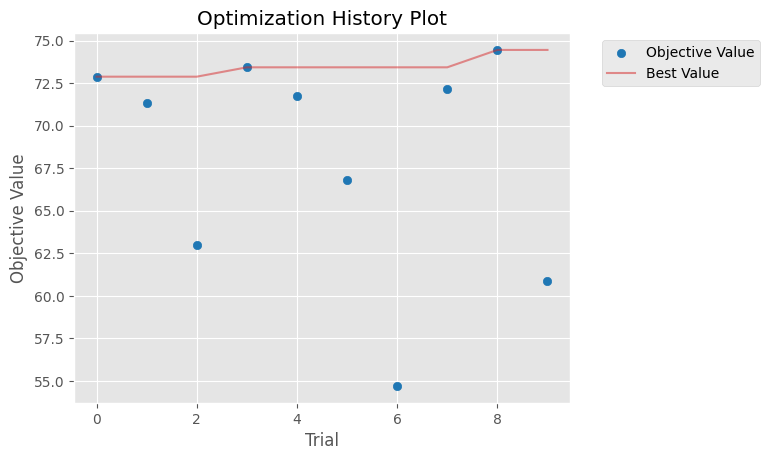

In [28]:
study = optuna.load_study(
    study_name="yield_round_1",
    storage="sqlite:///runs/greedy_optuna_10rounds_10_trials/round_1.db"
)

fig_ax = plot_optimization_history(study)
plt.show()

In [29]:
def visualize_logs(csv_path: str, out_dir: str | None = None, show: bool = False, dpi: int = 180):
    # 出力ディレクトリ（集約）
    root = out_dir or (os.path.dirname(csv_path) or ".")
    save_dir = os.path.join(root, "visualization")
    os.makedirs(save_dir, exist_ok=True)

    # ロード & 型整形
    df = pd.read_csv(csv_path)
    to_num_cols = [
        "round", "trial_index", "pred_yield_pct", "true_yield_pct",
        "error_pct", "study_best_pred", "study_best_true"
    ]
    for c in to_num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # 真値ありデータ
    df_obs = df.dropna(subset=["true_yield_pct"]) if "true_yield_pct" in df.columns else pd.DataFrame()
    # error_pct が無い/NaN の場合は再計算
    if not df_obs.empty:
        df_obs["error_pct"] = df_obs["pred_yield_pct"] - df_obs["true_yield_pct"]

    # ===== 全体指標 =====
    overall = {}
    if not df_obs.empty:
        y = df_obs["true_yield_pct"].to_numpy()
        yhat = df_obs["pred_yield_pct"].to_numpy()
        err = yhat - y
        overall = {
            "n": int(len(df_obs)),
            "mae_pct": float(np.mean(np.abs(err))),
            "rmse_pct": float(np.sqrt(np.mean(err**2))),
            "bias_pct": float(np.mean(err)),
            "r2": float(1 - np.sum(err**2) / np.sum((y - y.mean())**2)) if len(df_obs) > 1 else np.nan,
        }
    pd.DataFrame([overall]).to_csv(os.path.join(save_dir, "metrics_overall.csv"), index=False)

    # ===== ラウンド別指標（MAE/RMSE/Bias/R2）=====
    metrics_by_round = []
    if not df_obs.empty and "round" in df_obs.columns:
        for r, d in df_obs.groupby("round", dropna=True):
            y = d["true_yield_pct"].to_numpy()
            yhat = d["pred_yield_pct"].to_numpy()
            err = yhat - y
            metrics_by_round.append({
                "round": int(r),
                "n": int(len(d)),
                "mae_pct": float(np.mean(np.abs(err))),
                "rmse_pct": float(np.sqrt(np.mean(err**2))),
                "bias_pct": float(np.mean(err)),
                "r2": float(1 - np.sum(err**2) / np.sum((y - y.mean())**2)) if len(d) > 1 else np.nan,
            })
    mdf = (pd.DataFrame(metrics_by_round)
             .sort_values("round")
             if metrics_by_round else pd.DataFrame(columns=["round","n","mae_pct","rmse_pct","bias_pct","r2"]))
    mdf.to_csv(os.path.join(save_dir, "metrics_by_round.csv"), index=False)

    # ===== 図: パリティ =====
    if not df_obs.empty:
        fig = plt.figure(figsize=(5, 5))
        plt.scatter(df_obs["true_yield_pct"], df_obs["pred_yield_pct"], s=18, alpha=0.65)
        lims = [0, 100]
        plt.plot(lims, lims, linestyle="--")
        plt.xlim(lims); plt.ylim(lims)
        plt.xlabel("True Yield [%]"); plt.ylabel("Predicted Yield [%]")
        plt.title("Parity: Prediction vs Truth")
        fig.savefig(os.path.join(save_dir, "parity.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== 図: 誤差ヒスト =====
    if not df_obs.empty and not df_obs["error_pct"].dropna().empty:
        fig = plt.figure(figsize=(6, 4))
        plt.hist(df_obs["error_pct"].dropna().to_numpy(), bins=30)
        plt.xlabel("Prediction Error [%]  (pred - true)")
        plt.ylabel("Count")
        plt.title("Error Histogram")
        fig.savefig(os.path.join(save_dir, "error_hist.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== 図: ラウンド別ベスト真値 =====
    if not df_obs.empty and "round" in df_obs.columns:
        best_by_round = df_obs.groupby("round")["true_yield_pct"].max()
        fig = plt.figure(figsize=(6, 4))
        plt.plot(best_by_round.index, best_by_round.values, marker="o")
        plt.xlabel("Round"); plt.ylabel("Best Observed True Yield [%]")
        plt.title("Best True Yield per Round"); plt.grid(True, alpha=0.3)
        fig.savefig(os.path.join(save_dir, "best_true_per_round.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== 図: キャリブレーション =====
    if not df_obs.empty:
        bins = np.linspace(0, 100, 11)  # 10ビン
        cut = pd.cut(df_obs["pred_yield_pct"], bins, include_lowest=True)
        calib = df_obs.groupby(cut).agg(
            pred_mean=("pred_yield_pct", "mean"),
            true_mean=("true_yield_pct", "mean"),
            n=("true_yield_pct", "size")
        ).dropna()
        if not calib.empty:
            fig = plt.figure(figsize=(6, 4))
            lims = [0, 100]
            plt.plot(calib["pred_mean"], calib["true_mean"], marker="o")
            plt.plot(lims, lims, linestyle="--")
            plt.xlim(lims); plt.ylim(lims)
            plt.xlabel("Predicted Mean (per bin) [%]")
            plt.ylabel("Observed Mean (per bin) [%]")
            plt.title("Calibration Curve")
            fig.savefig(os.path.join(save_dir, "calibration.png"), dpi=dpi, bbox_inches="tight")
            if show: plt.show()
            plt.close(fig)
            calib.to_csv(os.path.join(save_dir, "calibration_table.csv"))

    # ===== 図: ラウンド別（真値/予測）の箱ひげ =====
    if not df_obs.empty and "round" in df_obs.columns:
        rounds = sorted(df_obs["round"].dropna().unique())
        if len(rounds) > 0:
            fig = plt.figure(figsize=(7, 4))
            pos = np.array(rounds, dtype=float)
            data_true = [df_obs[df_obs["round"] == r]["true_yield_pct"].to_numpy() for r in rounds]
            data_pred = [df_obs[df_obs["round"] == r]["pred_yield_pct"].to_numpy() for r in rounds]
            plt.boxplot(data_true, positions=pos - 0.15, widths=0.25, patch_artist=True)
            plt.boxplot(data_pred, positions=pos + 0.15, widths=0.25, patch_artist=True)
            plt.xticks(rounds)
            plt.xlabel("Round"); plt.ylabel("Yield [%]")
            plt.title("Distributions per Round (True vs Pred)")
            fig.savefig(os.path.join(save_dir, "round_box.png"), dpi=dpi, bbox_inches="tight")
            if show: plt.show()
            plt.close(fig)

    # ===== NEW: ラウンド別の誤差分布（箱ひげ）=====
    if not df_obs.empty and "round" in df_obs.columns:
        rounds = sorted(df_obs["round"].dropna().unique())
        if len(rounds) > 0:
            fig = plt.figure(figsize=(7, 4))
            data_err = [df_obs[df_obs["round"] == r]["error_pct"].dropna().to_numpy() for r in rounds]
            plt.boxplot(data_err, positions=np.array(rounds, dtype=float), widths=0.5, patch_artist=True)
            plt.axhline(0.0, linestyle="--")
            plt.xticks(rounds)
            plt.xlabel("Round"); plt.ylabel("Prediction Error (pred - true) [%]")
            plt.title("Prediction Error by Round (Boxplot)")
            fig.savefig(os.path.join(save_dir, "error_box_by_round.png"), dpi=dpi, bbox_inches="tight")
            if show: plt.show()
            plt.close(fig)

    # ===== NEW: ラウンド別の MAE/RMSE/Bias 推移 =====
    if not mdf.empty:
        fig = plt.figure(figsize=(7, 4))
        plt.plot(mdf["round"], mdf["mae_pct"], marker="o", label="MAE [%]")
        plt.plot(mdf["round"], mdf["rmse_pct"], marker="o", label="RMSE [%]")
        plt.plot(mdf["round"], mdf["bias_pct"], marker="o", label="Bias (pred-true) [%]")
        plt.xlabel("Round"); plt.ylabel("Error [%]")
        plt.title("Prediction Error by Round")
        plt.grid(True, alpha=0.3); plt.legend()
        fig.savefig(os.path.join(save_dir, "error_by_round.png"), dpi=dpi, bbox_inches="tight")
        if show: plt.show()
        plt.close(fig)

    # ===== Optuna study best =====
    if "study_best_pred" in df.columns:
        best_df = df.dropna(subset=["round", "study_best_pred"]).groupby("round").agg(
            best_pred=("study_best_pred", "max"),
            best_true=("study_best_true", "max")
        ).reset_index()
        if not best_df.empty:
            fig = plt.figure(figsize=(6, 4))
            plt.plot(best_df["round"], best_df["best_pred"], marker="o", label="Study Best Pred [%]")
            if "study_best_true" in best_df.columns and best_df["best_true"].notna().any():
                plt.plot(best_df["round"], best_df["best_true"], marker="o", label="Study Best True [%]")
            plt.xlabel("Round"); plt.ylabel("Yield [%]")
            plt.title("Optuna Study Best per Round"); plt.grid(True, alpha=0.3); plt.legend()
            fig.savefig(os.path.join(save_dir, "study_best.png"), dpi=dpi, bbox_inches="tight")
            if show: plt.show()
            plt.close(fig)

    return {"overall": overall, "by_round": mdf, "save_dir": save_dir}


/tmp/ipykernel_24238/2173484790.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_obs.groupby(cut).agg(


可視化完了! 保存先: runs/greedy_optuna_10rounds_10_trials/visualization


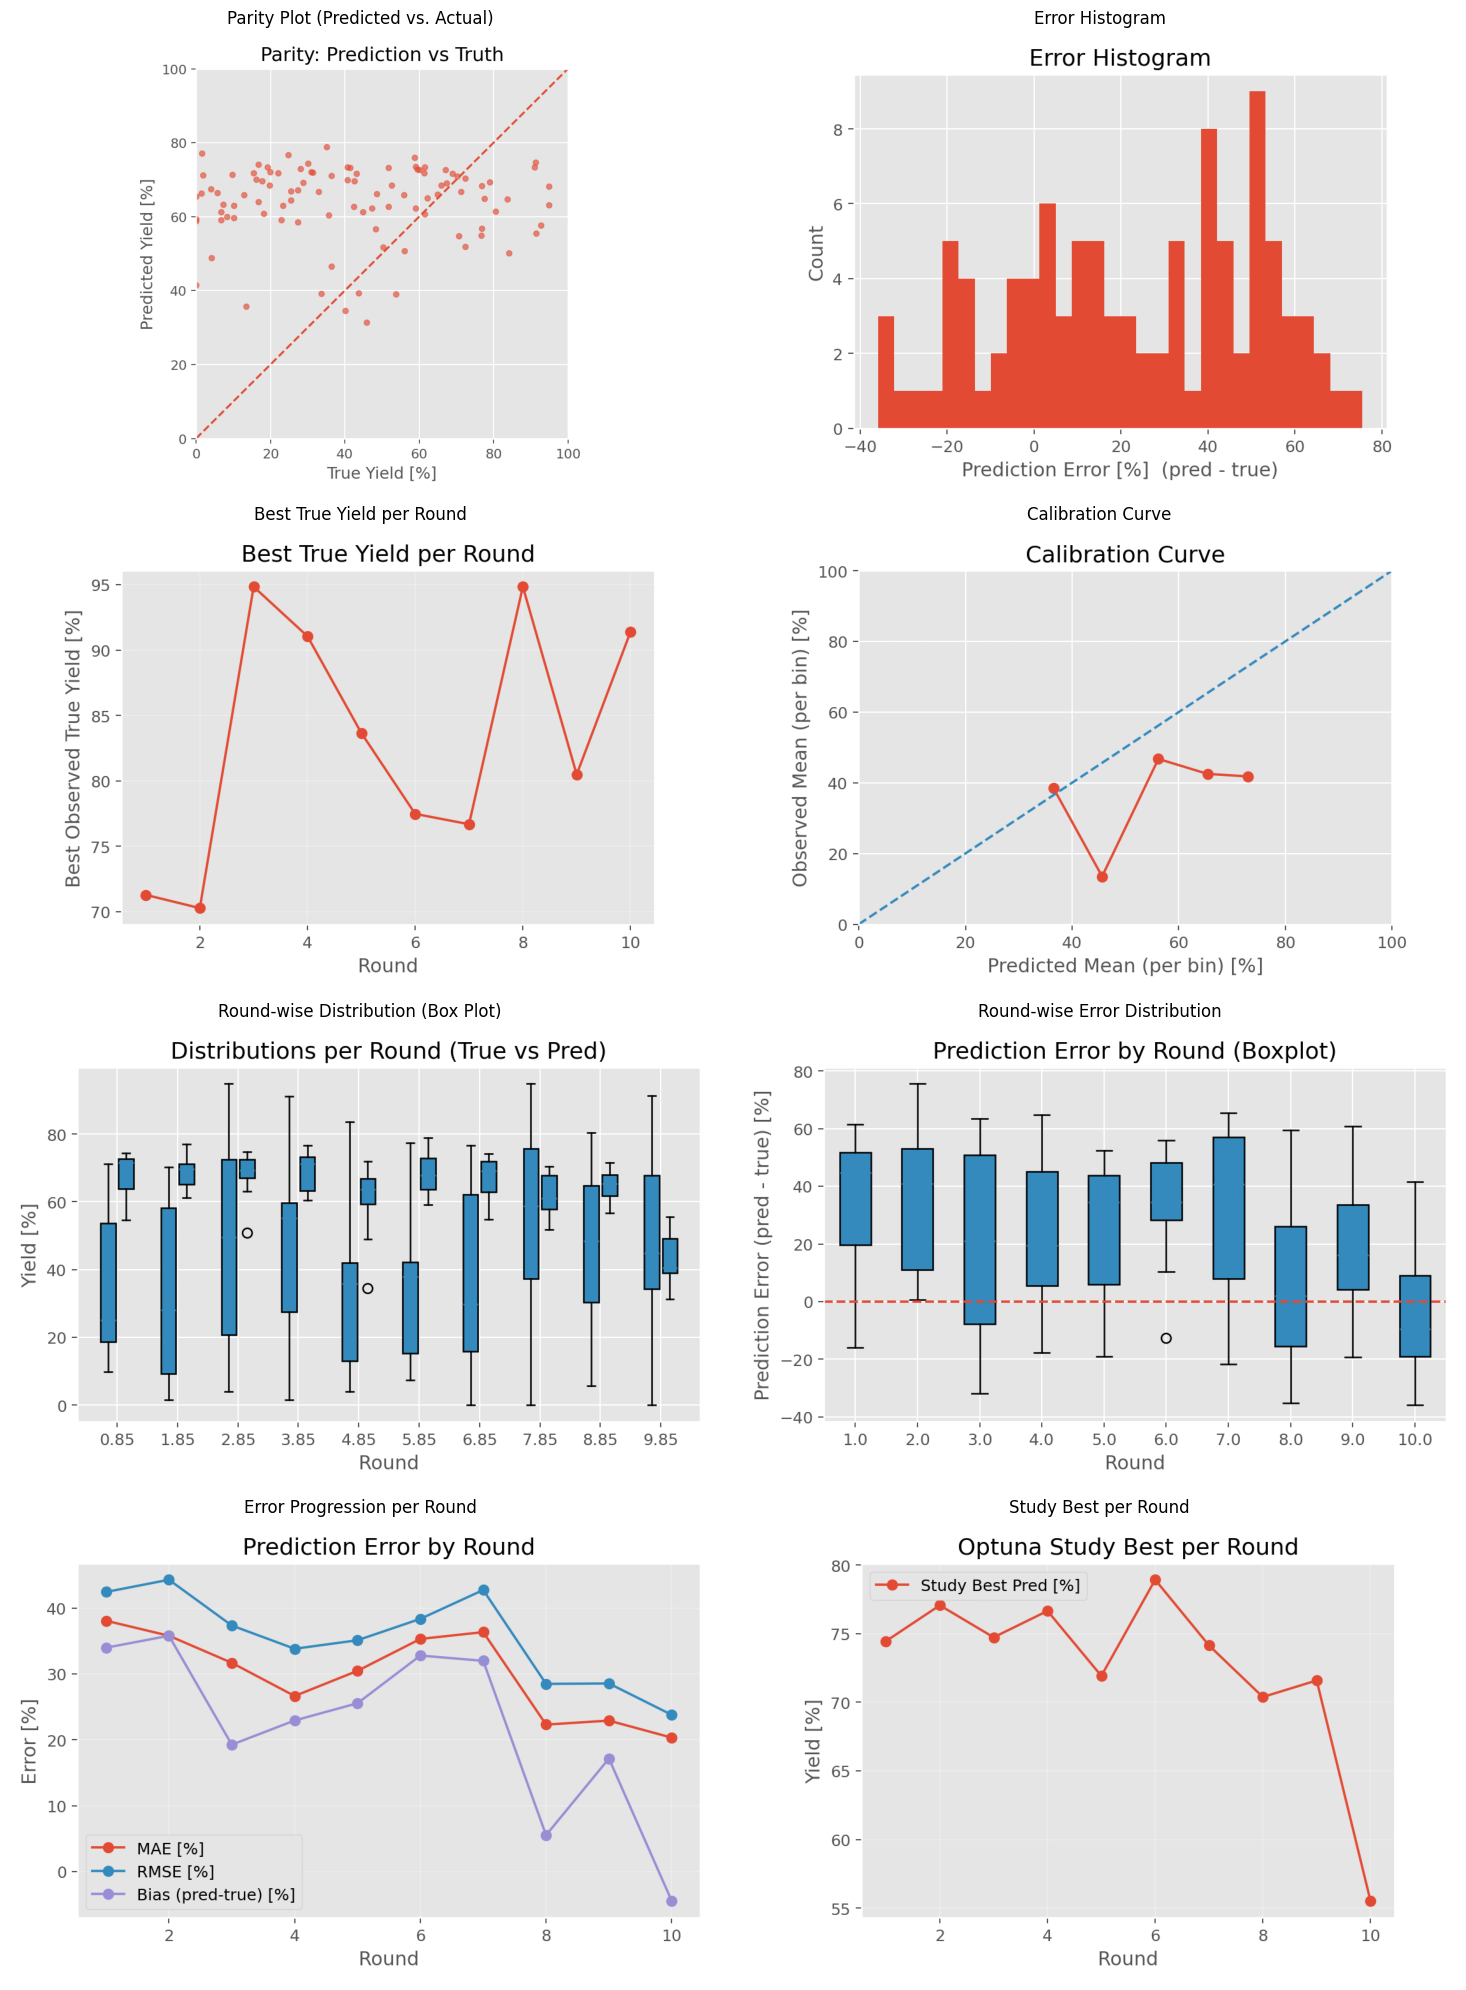

,n,mae_pct,rmse_pct,bias_pct,r2
0,100,29.98%,36.08%,22.05%,-0.792


,round,n,mae_pct,rmse_pct,bias_pct,r2
0,1,10,38.06%,42.43%,33.97%,-2.404
1,2,10,35.79%,44.28%,35.79%,-1.991
2,3,10,31.68%,37.34%,19.26%,-0.484
3,4,10,26.65%,33.81%,22.93%,-0.854
4,5,10,30.46%,35.10%,25.55%,-1.081
5,6,10,35.31%,38.35%,32.78%,-2.163
6,7,10,36.34%,42.72%,31.98%,-1.540
7,8,10,22.31%,28.49%,5.54%,0.011
8,9,10,22.91%,28.55%,17.15%,-0.515
9,10,10,20.33%,23.79%,-4.47%,0.262


In [30]:
def display_saved_plots(save_dir: str):
    """
    保存されたプロット画像をノートブックに表示
    
    Args:
        save_dir: 画像が保存されているディレクトリパス
    """
    import os
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from IPython.display import display, HTML
    
    # 期待される画像ファイル
    plot_files = [
        ("parity.png", "Parity Plot (Predicted vs. Actual)"),
        ("error_hist.png", "Error Histogram"),
        ("best_true_per_round.png", "Best True Yield per Round"),
        ("calibration.png", "Calibration Curve"),
        ("round_box.png", "Round-wise Distribution (Box Plot)"),
        ("error_box_by_round.png", "Round-wise Error Distribution"),
        ("error_by_round.png", "Error Progression per Round"),
        ("study_best.png", "Study Best per Round"),
    ]
    
    # グリッド形式で表示
    n_cols = 2
    n_rows = (len(plot_files) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    plot_idx = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if plot_idx < len(plot_files):
                filename, title = plot_files[plot_idx]
                filepath = os.path.join(save_dir, filename)
                
                if os.path.exists(filepath):
                    img = mpimg.imread(filepath)
                    axes[i, j].imshow(img)
                    axes[i, j].set_title(title, fontsize=12, pad=10)
                    axes[i, j].axis('off')
                else:
                    axes[i, j].text(0.5, 0.5, f'画像が見つかりません:\n{filename}', 
                                   ha='center', va='center', transform=axes[i, j].transAxes)
                    axes[i, j].set_title(title, fontsize=12, pad=10)
                    axes[i, j].axis('off')
                
                plot_idx += 1
            else:
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # メトリクス情報も表示
    metrics_file = os.path.join(save_dir, "metrics_overall.csv")
    if os.path.exists(metrics_file):
        import pandas as pd
        metrics_df = pd.read_csv(metrics_file)
        display(HTML("<h3>全体指標</h3>"))
        display(metrics_df.style.format({
            'mae_pct': '{:.2f}%',
            'rmse_pct': '{:.2f}%', 
            'bias_pct': '{:.2f}%',
            'r2': '{:.3f}'
        }))
    
    metrics_round_file = os.path.join(save_dir, "metrics_by_round.csv")
    if os.path.exists(metrics_round_file):
        import pandas as pd
        metrics_round_df = pd.read_csv(metrics_round_file)
        display(HTML("<h3>ラウンド別指標</h3>"))
        display(metrics_round_df.style.format({
            'mae_pct': '{:.2f}%',
            'rmse_pct': '{:.2f}%',
            'bias_pct': '{:.2f}%',
            'r2': '{:.3f}'
        }))

results = visualize_logs("runs/greedy_optuna_10rounds_10_trials/log.csv", show=False)
print("可視化完了! 保存先:", results["save_dir"])

# 保存された画像を表示
display_saved_plots(results["save_dir"])